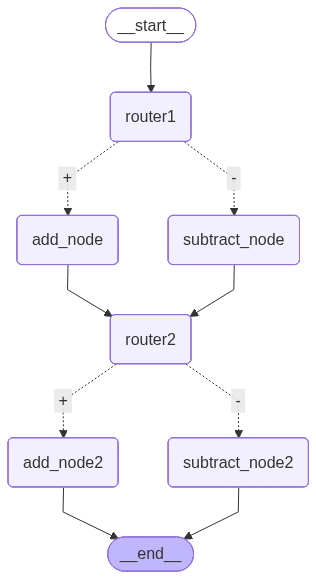

{'number1': 10,
 'operation': '+',
 'operation2': '-',
 'number2': 5,
 'finalNumber': 5}

In [5]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

# ------------------------------
# Define state schema
# ------------------------------
class AgentState(TypedDict):
    number1: int
    operation: str
    operation2: str
    number2: int
    finalNumber: int

# ------------------------------
# Node functions
# ------------------------------
def adder(state: AgentState) -> AgentState:
    state["finalNumber"] = state["number1"] + state["number2"]
    return state

def subtractor(state: AgentState) -> AgentState:
    state["finalNumber"] = state["number1"] - state["number2"]
    return state

# ------------------------------
# Router functions
# ------------------------------
def decide_op1_node(state: AgentState) -> str:
    if state['operation'] == "+":
        return "+"
    elif state['operation'] == "-":
        return "-"
    else:
        raise ValueError("Unsupported operation")

def decide_op2_node(state: AgentState) -> str:
    if state['operation2'] == "+":
        return "+"
    elif state['operation2'] == "-":
        return "-"
    else:
        raise ValueError("Unsupported operation")

# ------------------------------
# Build the graph
# ------------------------------
graph = StateGraph(AgentState)

# Add computation nodes
graph.add_node("add_node", adder)
graph.add_node("subtract_node", subtractor)
graph.add_node("add_node2", adder)
graph.add_node("subtract_node2", subtractor)

# Add router nodes (pass state unchanged)
graph.add_node("router1", lambda state: state)
graph.add_node("router2", lambda state: state)

# START -> router1
graph.add_edge(START, "router1")

# router1 -> first operation with labeled edges
graph.add_conditional_edges(
    "router1",
    decide_op1_node,
    {
        "+": "add_node",
        "-": "subtract_node"
    }
)

# first operation -> router2
graph.add_edge("add_node", "router2")
graph.add_edge("subtract_node", "router2")

# router2 -> second operation with labeled edges
graph.add_conditional_edges(
    "router2",
    decide_op2_node,
    {
        "+": "add_node2",
        "-": "subtract_node2"
    }
)

# second operation -> END
graph.add_edge("add_node2", END)
graph.add_edge("subtract_node2", END)

# Compile the graph
app = graph.compile()

# ------------------------------
# Visualize
# ------------------------------
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

# ------------------------------
# Example invocation
# ------------------------------
init_state = AgentState(number1=10, number2=5, operation="+", operation2="-", finalNumber=0)
app.invoke(init_state)
